# Implementing self-attention

Let's implement a Transformer. Don't worry, we can do this.

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def num_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

## Getting started

Let's start with an input sequence.

In [2]:
sentence = "Transformed."

Let's turn it into numbers by using the Unicode code point for each character. To keep things simple, we won't batch anything.

In [3]:
sentence_tensor = torch.tensor([ord(x) for x in sentence])
sentence_tensor

tensor([ 84, 114,  97, 110, 115, 102, 111, 114, 109, 101, 100,  46])

In [4]:
def decode(x):
    return ''.join(chr(x) for x in x.numpy())
decode(sentence_tensor)

'Transformed.'

We'll make this an autoregressive language model, so our goal will be to predict the next character. So we'll need to shift the targets left, so each character should output the next one.

In [5]:
targets = sentence_tensor[1:]
input_ids = sentence_tensor[:-1]
assert input_ids.shape == targets.shape

Now let's make those numbers into vectors using an embedding. Note that we're just going to use the random initialization right now; we're not yet training this model.

# Embeddings

A big chunk of the parameters of a model come from the *word embeddings*. Let's see an example.

We'll use a vocabulary size of 256 (very small, but enough to store individual *bytes*) and an embedding dimensionality of 5 (also *very* small).

(Note: we'll still call these *word* embeddings even though we'll actually use them as embeddings for individual *characters*.)

In [6]:
n_vocab = 256
emb_dim = 5
embedder = nn.Embedding(n_vocab, emb_dim)
embedder.weight.shape

torch.Size([256, 5])

How many parameters are needed for the word embeddings?

In [7]:
num_parameters(embedder)

1280

## Complete but vacuous model

We'll now define a model that has the outward structure of a language model, but without any internal processing.

In [8]:
class BareBonesLM(nn.Module):
    def __init__(self, n_vocab, emb_dim, tie_weights=True, bias=False):
        super().__init__()
        self.word_to_embedding = nn.Embedding(n_vocab, emb_dim)
        self.lm_head = nn.Linear(emb_dim, n_vocab, bias=bias)

        if tie_weights:
            assert self.lm_head.weight.shape == self.word_to_embedding.weight.shape
            self.lm_head.weight = self.word_to_embedding.weight
    
    def forward(self, input_ids):
        input_embeds = self.word_to_embedding(input_ids)
        x = input_embeds # model would go here
        logits = self.lm_head(x)
        return logits


num_parameters(BareBonesLM(n_vocab=n_vocab, emb_dim=emb_dim))

1280

## Multi-Layer Perceptron

Now let's start putting a model in there. Let's start with the simple MLP that we looked at in previous Fundamentals. We'll define it as a PyTorch `Module`:

In [10]:
class MLP(nn.Module):
    def __init__(self, emb_dim, n_hidden):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=emb_dim, out_features=n_hidden),
            nn.ReLU(), # or nn.GELU() or others
            nn.Linear(in_features=n_hidden, out_features=emb_dim)
        )

    def forward(self, x):
        return self.model(x)

num_parameters(MLP(emb_dim=emb_dim, n_hidden=16))

181

### Complete Language Model with MLP

Now let's put that into an LM. Notice what's similar and what's different between this and the `BareBonesLM` above.

In [11]:
class FeedForwardLM(nn.Module):
    def __init__(self, n_vocab, emb_dim, n_hidden, tie_weights=True):
        super().__init__()
        self.word_to_embedding = nn.Embedding(n_vocab, emb_dim)
        self.model = MLP(emb_dim=emb_dim, n_hidden=n_hidden)
        self.lm_head = nn.Linear(emb_dim, n_vocab, bias=False)

        if tie_weights:
            assert self.lm_head.weight.shape == self.word_to_embedding.weight.shape
            self.lm_head.weight = self.word_to_embedding.weight
    
    def forward(self, input_ids):
        input_embeds = self.word_to_embedding(input_ids)
        x = self.model(input_embeds)
        return self.lm_head(x)


ff_lm = FeedForwardLM(n_vocab=n_vocab, emb_dim=emb_dim, n_hidden=16)
num_parameters(ff_lm)

1461

## Self-Attention

We're going to implement an oversimplified Self-Attention layer. If you're interested, here are a few reference implementations of the real thing:

- https://github.com/jaymody/picoGPT/
- [Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
- PyTorch's builtin implementation: [`TransformerEncoderLayer`](https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#TransformerEncoderLayer) and [`MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention).
- [minGPT](https://github.com/karpathy/minGPT/blob/master/mingpt/model.py)

First we'll do it step-by-step, then we'll bundle it into a module.

To show what's going on, let's get some example input embeddings.

In [12]:
example_embeddings = embedder(input_ids)
example_embeddings.shape

torch.Size([11, 5])

**Stop**: Can you explain that shape?

We're going to implement a single attention head. Recall that we need to compute three things for each token: a **query** (q), which then gets compared with all of the **key**s (k), and if matches, we add up the **value**s (v). Let's do that. First, let's define linear layers to compute q, k, and v.

In [13]:
# In the real model, this will be defined in the __init__ method
# Note: some models include biases here, others don't.
get_query = nn.Linear(emb_dim, emb_dim, bias=False)
get_key = nn.Linear(emb_dim, emb_dim, bias=False)
get_value = nn.Linear(emb_dim, emb_dim, bias=False)

Then, when we do a forward pass, we compute q, k, and v for each token. We do that by passing the input embeddings through the linear layers.

In [14]:
queries = get_query(example_embeddings)
keys = get_key(example_embeddings)
values = get_value(example_embeddings)

In [15]:
print(keys)
print(values)

tensor([[-0.2916, -0.3433, -0.2521, -0.3284, -1.0059],
        [ 0.3273, -0.0719,  0.5047, -0.4297, -0.3397],
        [ 1.3166,  0.1883,  0.9023, -0.9228, -0.0918],
        [ 0.1294,  0.3409, -0.5682, -0.0680,  0.5885],
        [ 0.3143, -0.7208,  0.9736, -0.5665,  0.5211],
        [ 0.1223,  1.3094, -0.9502,  1.2695,  0.7920],
        [ 1.3500,  0.8064, -0.9179, -0.1764, -0.1567],
        [ 0.3273, -0.0719,  0.5047, -0.4297, -0.3397],
        [-0.6557, -0.1387,  0.5381,  0.1338,  0.2822],
        [ 0.9047,  0.0556,  0.6296, -0.2736,  0.0454],
        [-0.4114,  0.1518, -0.4654,  0.5439,  0.6163]], grad_fn=<MmBackward0>)
tensor([[ 0.0449, -0.1159,  0.3450, -0.0856, -0.3063],
        [ 0.4874, -0.4537,  0.1441, -0.5479, -0.3431],
        [ 1.0906, -0.9954, -0.2482, -1.2250, -0.5048],
        [ 0.2326,  0.6712,  0.0739, -0.3251,  0.5278],
        [ 0.3719, -0.2640, -0.3922, -0.4245, -0.4344],
        [-0.8104,  0.3224, -0.3869,  0.9885,  0.9078],
        [-0.0183, -0.6592, -1.0289,  0.02

**Stop**: What shape will `queries` have? What about `keys` and `values`? Check your answers by printing them out.

Now, let's compute how how much each token's query matches each token's key. We do that by computing the dot product of each query with each key. We could do something like:

In [16]:
query_2_key_1 = queries[2] @ keys[1]

But that would be tedious and require looping. Instead, we can just compute a matrix multiplication.

In [17]:
query_key_products = queries @ keys.T
query_key_products.shape

torch.Size([11, 11])

In [18]:
# Check that it's computing the same thing.
assert torch.allclose(query_2_key_1, query_key_products[2, 1])

The result is a matrix of dot products. Let's look at it. (Note: since the embeddings and the linear layers are random, your values will be different.)

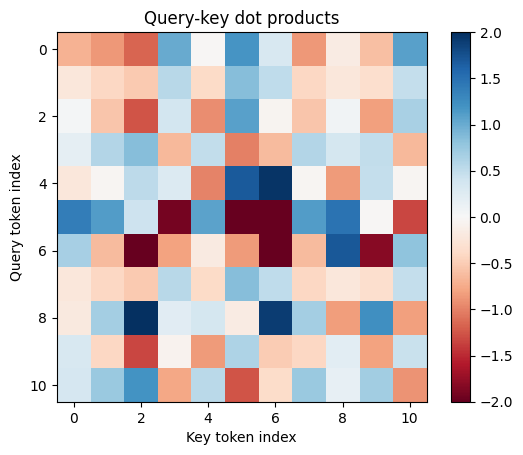

In [19]:
# center the color scale on 0.
plt.imshow(query_key_products.detach().numpy(), cmap="RdBu", vmin=-2, vmax=2)
plt.title("Query-key dot products")
plt.xlabel("Key token index")
plt.ylabel("Query token index")
plt.colorbar();

We then use the softmax function to compute how much to actually pay attention to each token. It turns out that to stabilize the computation, it helps to use a temperature proportional to the square root of the dimensionality of the keys.

In [20]:
attention_weights = F.softmax(query_key_products / emb_dim**0.5, dim=-1)

What do the attention weights look like?

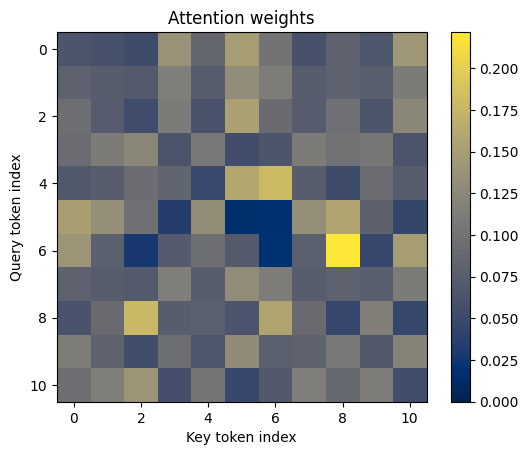

In [21]:
plt.imshow(attention_weights.detach().numpy(), cmap="cividis", vmin=0)
plt.title("Attention weights")
plt.xlabel("Key token index")
plt.ylabel("Query token index")
plt.colorbar();

Those weights determine, for each token, how much of each other token's `value` to add up. We can compute that by multiplying the weights by the values.

In [22]:
first_token_output = attention_weights[0] @ values
first_token_output.shape # notice that this is the same shape as the input embeddings

torch.Size([5])

Again, we can io the computation all at once by computing a matrix multiplication.

In [23]:
head_output = attention_weights @ values
assert torch.allclose(first_token_output, head_output[0])

The full attention mechanism has this go through another linear layer, but we'll skip that for now.

But wait! Tokens shouldn't be able to attend to tokens that come after them. We need to mask out the attention weights for those tokens.

A simple way to do that is to set the dot products to a very small value for tokens that come after the current token. That way, when we apply the softmax, the attention weights will be very close to zero.

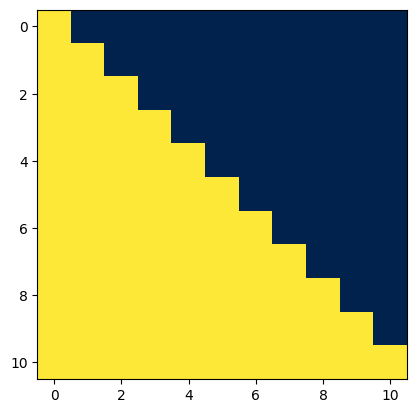

In [24]:
sequence_len = input_ids.shape[0]
causal_mask = (1 - torch.tril(torch.ones(sequence_len, sequence_len))) * -1e9
plt.imshow(causal_mask.detach().numpy(), cmap="cividis", vmin=-1e9)

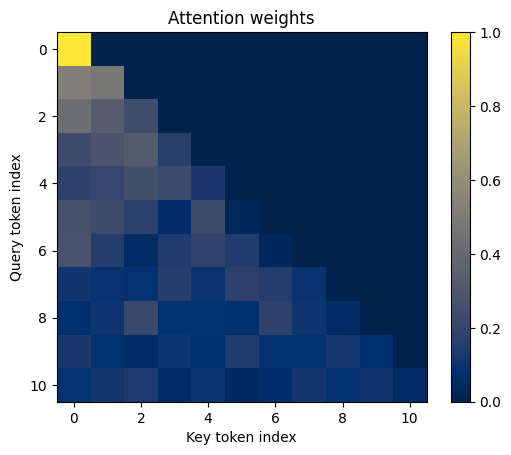

In [25]:
attention_weights = F.softmax((query_key_products + causal_mask) / emb_dim**0.5, dim=-1)
plt.imshow(attention_weights.detach().numpy(), cmap="cividis", vmin=0)
plt.title("Attention weights")
plt.xlabel("Key token index")
plt.ylabel("Query token index")
plt.colorbar();

Now we can bundle that into a `Module`. Your task: add the causal masking.

In [26]:
class BareBonesAttentionHead(nn.Module):
    '''Implements *single-head* attention, no masking, no dropout, no init'''
    def __init__(self, emb_dim, head_dim):
        super().__init__()
        self.head_dim = head_dim
        self.get_query = nn.Linear(emb_dim, head_dim, bias=False)
        self.get_key = nn.Linear(emb_dim, head_dim, bias=False)
        self.get_value = nn.Linear(emb_dim, head_dim, bias=False)

    def forward(self, x):
        seq_len, emb_dim = x.shape

        # Compute query, key, and value vectors.
        q = self.get_query(x) # (seq_len, head_dim)
        k = self.get_key(x)
        v = self.get_value(x)

        # Compute attention weights
        k_transpose = k.transpose(-2, -1)
        assert k_transpose.shape == (self.head_dim, seq_len)
        scores = q @ k_transpose
        assert scores.shape == (seq_len, seq_len)
        attention_weights = scores.softmax(dim=-1)

        # Compute weighted sum of values.
        out = attention_weights @ v
        return out

class BareBonesSelfAttention(nn.Module):
    def __init__(self, emb_dim, head_dim, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([
            BareBonesAttentionHead(emb_dim, head_dim)
            for i in range(n_heads)
        ]) # we need a ModuleList to make sure the heads are counted as children.
        self.to_output = nn.Linear(n_heads * head_dim, emb_dim, bias=False)

    def forward(self, x):
        head_outputs = [head(x) for head in self.heads]
        concats = torch.cat(head_outputs, dim=-1)
        out = self.to_output(concats)
        assert out.shape == x.shape
        return out

input_embeds = embedder(sentence_tensor)
self_attn = BareBonesSelfAttention(emb_dim, head_dim=256, n_heads=2)
self_attn(input_embeds).shape


torch.Size([12, 5])

Now we'll define a Transformer. Well, we'll just define a single layer. A true Transformer will have many (32, 64, 118, ...) such layers. But it's just running a bunch of copies of this layer in sequence.

One new thing here is the *layer norm*. It basically rescales the activations to be mean 0 variance 1, then scales and shifts by learnable constants. So each one adds 2 * emb_dim parameters to the model, and there's one after each part (self-attention and MLP).

In [27]:
class BareBonesTransformerLayer(nn.Module):
    '''Implements bare-bones self-attention transformer layer, no residual connections, no dropout'''
    def __init__(self, emb_dim, head_dim, n_heads, dim_feedforward):
        super().__init__()
        self.self_attention = BareBonesSelfAttention(emb_dim, head_dim=head_dim, n_heads=n_heads)
        self.mlp = MLP(emb_dim, n_hidden=dim_feedforward)
        self.norm_after_attn = nn.LayerNorm(emb_dim)
        self.norm_after_mlp = nn.LayerNorm(emb_dim)
    
    def forward(self, x):
        x = self.self_attention(x)
        x = self.norm_after_attn(x)
        x = self.mlp(x)
        x = self.norm_after_mlp(x)
        return x

xformer_layer = BareBonesTransformerLayer(emb_dim, dim_feedforward=emb_dim, head_dim=256, n_heads=2)
xformer_layer(input_embeds).shape

torch.Size([12, 5])

Now, at long last, let's make a complete Transformer-based language model.

A big new aspect here is the *position embeddings*. We'll implement *learned absolute position embeddings*, which do add parameters to the model. A cool new approach, called *Rotary Position Embeddings* ([RoPE](https://blog.eleuther.ai/rotary-embeddings/)), gets comparable or better performance without adding parameters; for an implementation of that, see [x-transformers](https://github.com/lucidrains/x-transformers/blob/75afacae30c3a6c9a9daf6f9403c3fc22f6bc945/x_transformers/x_transformers.py#L310).

In [28]:
class TransformerLM(nn.Module):
    def __init__(self, n_vocab, max_len, emb_dim, n_hidden, head_dim=256, n_heads=2):
        super().__init__()
        self.word_to_embedding = nn.Embedding(n_vocab, emb_dim)
        self.pos_to_embedding = nn.Embedding(max_len, emb_dim)
        self.model = BareBonesTransformerLayer(
            emb_dim=emb_dim, dim_feedforward=n_hidden,
            head_dim=head_dim, n_heads=n_heads)
        self.lm_head = nn.Linear(emb_dim, n_vocab, bias=False)

        assert self.lm_head.weight.shape == self.word_to_embedding.weight.shape
        self.lm_head.weight = self.word_to_embedding.weight
    
    def forward(self, input_ids):
        input_embeds = self.word_to_embedding(input_ids)
        # Compute position embeddings.
        position_ids = torch.arange(input_ids.shape[-1])
        pos_embeds = self.pos_to_embedding(position_ids)
        x = input_embeds + pos_embeds
        x = self.model(x)
        return self.lm_head(x)


xformer_lm = TransformerLM(n_vocab=n_vocab, max_len=50, emb_dim=emb_dim, n_hidden=16)
num_parameters(xformer_lm)

11971